# Clasificación: homework

------------------------------------------------------


### Data Science and Machine Learning

#### Febrero 2023

**Aurora Cobo Aguilera**

**The Valley**

------------------------------------------------------

In [1]:
from IPython.core.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import multivariate_normal, norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

from warnings import filterwarnings
filterwarnings('ignore')

# Configuración de las figuras matplotlib
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 12})

In [2]:
def load_data():
  data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                     delimiter=" ",
                     header=None)
  data.columns=['existingchecking', 
                'duration', 
                'credithistory', 
                'purpose', 
                'creditamount', 
                'savings', 
                'employmentsince', 
                'installmentrate', 
                'statussex', 
                'otherdebtors', 
                'residencesince', 
                'property', 
                'age', 
                'otherinstallmentplans', 
                'housing', 
                'existingcredits', 
                'job', 
                'peopleliable', 
                'telephone', 
                'foreignworker', 
                'target'
                ]
  data.loc[:,'target'] = data['target'].replace([1,2],[1,0])
  return data

In [3]:
def muestra_frontera(X_train,Y_train,x1_grid=None,x2_grid=None,probs_grid=None,dataset=False,frontera=False,thresholds=[0.5],
                     prob_levels=False, titulo='Datos',xlabel='$x_1$',ylabel='$x_2$'):
    
    """
    - dataset=True --> Representamos solo el dataset
    - frontera=True --> Representamos dataset con frontera de decisión (podemos especificar mas niveles con thresholds)
    - prob_levels=True --> Representamos dataset con curvas de nivel de probabilidad de clase 1.
    """
    
    clases = np.unique(Y_train).astype(np.int32)
    labels = ['Class ' + str(int(c)) for c in clases]
    
    if(dataset==True):
        
        plt.figure()
        for c in clases:
            plt.plot(X_train[Y_train==c,0],X_train[Y_train==c,1],'s',label=labels[c])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper right')
        plt.title(titulo)
        plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
        plt.show()
    
    if(frontera==True):
        plt.figure()
        for c in clases:
            plt.plot(X_train[Y_train==c,0],X_train[Y_train==c,1],'s',label=labels[c])
        plt.contour(x1_grid,x2_grid,np.reshape(probs_grid[:,1],np.shape(x1)),thresholds,linestyles='dashed')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper right')
        plt.title(titulo)
        # Principales líneas de la rejilla
        plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
        plt.show()

    if(prob_levels==True):
        fig,ax = plt.subplots()
        for c in clases:
            ## Dibujamos los datos de entrenamiento
            plt.plot(X_train[Y_train==c,0],X_train[Y_train==c,1],'s',label=labels[c])
        cs = ax.contourf(x1_grid,x2_grid,np.reshape(probs_grid[:,1],np.shape(x1)),np.arange(0,1.1,0.0005),linestyles='dashed',cmap='Greys')
        cbar = fig.colorbar(cs)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper right')
        plt.title(titulo)
        # Principales líneas de la rejilla
        plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
        plt.show()


# Ejercicio 1
---

En este primer ejercicio, vamos a recuperar uno de los conjunto de datos de 2 dimensiones que usamos en la sesión de clasificación.

En el siguiente código lo cargamos, normalizamos y dividimos en train/test.


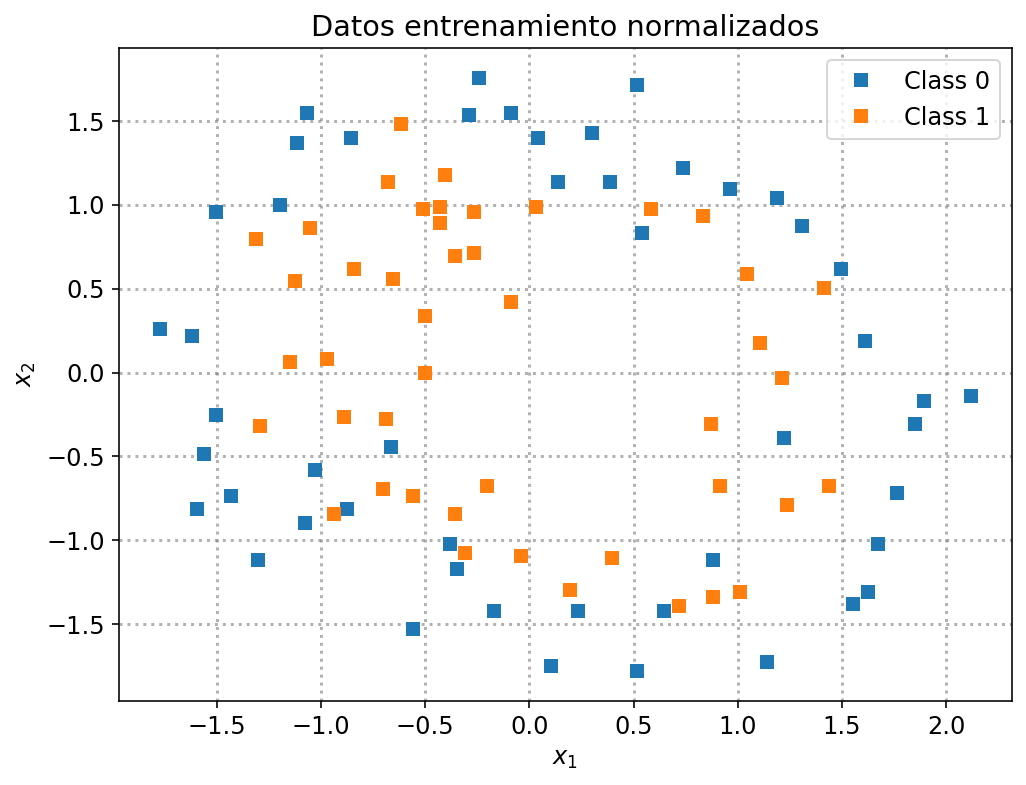

In [4]:
data_ejemplo2 = pd.read_csv('http://www.tsc.uc3m.es/~olmos/BBVA/ejemplo2.txt',header=None)

data_ejemplo2.head(10)

data = np.array(data_ejemplo2)

## Dimensiones
dims=np.shape(data)
N=dims[0]

## Separamos X e Y
X2=data[:,0:2]
Y2=data[:,2]

# Separamos train de test
X02_train, X02_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=50)

# Variables para la representación de la frontera de decisión (antes de normalizar!)
min1=np.min(X02_train[:,0])
max1=np.max(X02_train[:,0])
min2=np.min(X02_train[:,1])
max2=np.max(X02_train[:,1])

# Normalizamos los datos (media 0, varianza 1)

transformer = StandardScaler().fit(X02_train)

X2_train = transformer.transform(X02_train)
X2_test = transformer.transform(X02_test)

# Representaciones usando la función muestra_frontera
muestra_frontera(X_train=X2_train,Y_train=Y2_train,
                 dataset=True,titulo='Datos entrenamiento normalizados')

En este ejercicio, vamos a entrenar un RL sobre este problema pero utilizando una representación en [**coordenadas polares**](https://es.wikipedia.org/wiki/Coordenadas_polares). Esto es, dado cada punto $\mathbf{x}=(x_1,x_2)$, entrenaremos un RL de la forma


$$P(Y=1| {\bf x}) =  \frac{1}{1+\exp(-{\bf w}^T {\phi(\mathbf{x})})}=\sigma({\bf w}^T {\phi(\mathbf{x})})$$

donde $\phi(\mathbf{x})=[r,a]$, $r = \sqrt{x_1^2+x_2^2}$ y $a = \arctan(\frac{x_2}{x_1})$.

### Paso 1 

Convierta la base de datos normalizada (`X2_train`, `X2_test`) a coordenadas polares. Utilice las funciones `np.linalg.norm` para el cálculo de $r$ y `np.arctan2` para obtener $a$. 

In [ ]:
np.info(np.arctan2)

In [30]:
def coordenadas_polares(X):
    
    #r = np.linalg.norm(np.sqrt((X.reshape([-1,1])**2))+ (X.reshape([-1,1])**2))
    r = np.linalg.norm(X.reshape([-1,1]), axis = 0 )
    a = np.arctan2(X.reshape([-1,1]),X.reshape([-1,1]))
    
    return np.hstack([r,a])


pol_train = coordenadas_polares(X02_train)#<SOL> # Datos de training en polares
pol_test = coordenadas_polares(X02_test)#<SOL> # Datos de test en polares

ValueError: ignored

### Paso 2

Represente los datos de entrenamiento en función de $r$ y $a$. Discuta el resultado. ¿Cree que tanto $r$ como $\alpha$ son variables igualmente discriminativas para separar las clases?

In [ ]:
# Representaciones usando la función muestra_frontera
muestra_frontera(X_train=#<SOL>,
                 Y_train=#<SOL>,
                 dataset=True, 
                 titulo='Datos entrenamiento, normalizados y en coordenadas polares', 
                 xlabel = '$r$',ylabel='$a$')

### Paso 3

Entrene un RL utilizando únicamente la variable $r$. Discuta el resultado a la vista de las representaciones obtenidas.

In [ ]:
# Entrenar RL en una dimension. 

from sklearn.linear_model import LogisticRegression as LR

mi_RL_r = LR(C=1e8) 

mi_RL_r.fit(#<SOL>)

n_points = 50
#Obtenemos una rejilla de puntos en los que evaluaremos nuestro RL
x1,x2 = np.mgrid[min1:max1:(max1-min1)/n_points, min2:max2:(max2-min2)/n_points]
grid = np.transpose(np.row_stack([x1.ravel(), x2.ravel()]))
# Normalizamos la rejilla
grid_norm = transformer.transform(grid)

# Pasamos la rejilla a polares
grid_pol = #<SOL>

#Estimamos la probabilidad asociada a cada punto de la rejilla con el método .predic_proba
probs_LR_r = mi_RL_r.predict_proba(#<SOL>)

# Representaciones usando la función muestra_frontera 
muestra_frontera(x1_grid=grid_norm[:,0].reshape([n_points,n_points]),
                 x2_grid=grid_norm[:,1].reshape([n_points,n_points]),
                 probs_grid=probs_LR_r,X_train=X2_train,Y_train=Y2_train,
                 prob_levels=True,titulo='RL datos normalizados en cartesianas')

muestra_frontera(x1_grid=grid_pol[:,0].reshape([n_points,n_points]),
                 x2_grid=grid_pol[:,1].reshape([n_points,n_points]),
                 probs_grid=probs_LR_r,X_train=pol_train,Y_train=Y2_train,
                 frontera=True,titulo='RL datos normalizados en polares',xlabel = '$r$',ylabel='$a$',
                thresholds=[0.5,0.7,0.9])

muestra_frontera(x1_grid=grid_pol[:,0].reshape([n_points,n_points]),
                 x2_grid=grid_pol[:,1].reshape([n_points,n_points]),
                 probs_grid=probs_LR_r,X_train=pol_train,Y_train=Y2_train,
                 prob_levels=True,titulo='RL datos normalizados en polares', xlabel = '$r$',ylabel='$a$')

### Paso 4

Calcule la fracción de datos correctamente clasificados tanto en el conjunto de entrenamiento como en el de test. Compare con los resultados obtenidos en el notebook visto en clase.

In [ ]:
#<SOL>

#</SOL>

# Ejercicio 2 
---

Utilizando la base de datos *german* en la que se han codificado de forma adecuado las variables categóricas, compare las prestaciones en un conjunto de test de los siguientes clasificadores en términos de área bajo la curva ROC (AUC-ROC) y F1-score: 

- k-NN, validando el número de vecinos, la ponderación de distancias.
- Regresión Logística con regularización L2, validando el parámetro $C$ de regularización.
- LDA (Lineal Discriminant Analysis).
- Random Forest validando tanto el número de estimadores y el máximo número de hojas.

Represente también en una única gráfica la curva ROC de los cuatro clasificadores. En todos los casos, seleccione rangos de validación adecuados para cada hiperparámetro.



In [ ]:
#<SOL>

#</SOL>

# Ejercicio 3 

En este último ejercicio, vamos a estudiar las prestaciones de un regresor logístico y un k-NN para clasificar imágenes de números. Cada imagen es de $8x8$ pixeles. Vamos a tratar los píxeles como variables independientes, así que cada dato de entrada tiene 64 dimensiones.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data # Números
Y = digits.target # Etiquetas

print("Hay un total de {0:d} imagenes, cada una contiene {1:d} pixels".format(X.shape[0],X.shape[1]))

Dibujemos algunas imágenes de muestra.

In [ ]:
def plot_digits(data):
    fig, axes = plt.subplots(1, 10, figsize=(10, 10),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        
plot_digits(X)

En este ejercicio se pide construir dos clasificadores multi-clase basados en k-NN y regresión logística utilizando la estrategia OneVsRest. Para cada uno de ellos, se pide analizar:
- El número de imágenes correctamente detectadas tanto en el conjunto de entrenamiento como el de test. 
- F1 score y precision en test de cada uno de los clasificadores binarios entrenados internamente.
- Matriz de confusión y la tasa de error en clasificación (tanto en train como en test) para cada número.

Previamente, divida el conjunto de datos en entrenamiento y test y normalize las entradas.

In [ ]:
#<SOL>

#</SOL>

# Ejercicio 4 

Represente la matriz de confusión de un esquema OneVsOne y discuta las diferencias. ¿Cuántos clasificadores estamos entrenando en este caso?

In [ ]:
#<SOL>

#</SOL>